In [2]:
from helpers import *

import shutil


import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


import datetime
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


from collections import OrderedDict
from itertools import product



linestyles = OrderedDict(
    [

     ('loosely dashed',      (0, (5, 20))),
     ('dashed',              (0, (3, 2))),
     ('densely dashed',      (0, (1, 3))),

    ])

# Data Processing

## Importing data

In [3]:
def load_kaggle_data(path):
    data = pd.read_csv(path)
    data.replace({'\\N':np.nan}, inplace=True)
    return data

data_dir ='kaggle-data/'

circuits_raw_df = load_kaggle_data(f'{data_dir}/circuits.csv')
constructors_raw_df = load_kaggle_data(f'{data_dir}/constructors.csv')
constructor_standings_raw_df = load_kaggle_data(f'{data_dir}/constructor_standings.csv')
driver_standings_raw_df = load_kaggle_data(f'{data_dir}/driver_standings.csv')
drivers_raw_df = load_kaggle_data(f'{data_dir}/drivers.csv')
laptimes_raw_df = load_kaggle_data(f'{data_dir}/lap_times.csv')
pitstops_raw_df = load_kaggle_data(f'{data_dir}/pit_stops.csv')
qualifying_raw_df = load_kaggle_data(f'{data_dir}/qualifying.csv')
races_raw_df = load_kaggle_data(f'{data_dir}/races.csv')
results_raw_df = load_kaggle_data(f'{data_dir}/results.csv')
seasons_raw_df = load_kaggle_data(f'{data_dir}/seasons.csv')
sprint_results = load_kaggle_data(f'{data_dir}/sprint_results.csv')
status_raw_df = load_kaggle_data(f'{data_dir}/status.csv')

print('circuits_raw_df', circuits_raw_df.columns)
print('constructors_raw_df', constructors_raw_df.columns)
print('constructor_standings_raw_df', constructor_standings_raw_df.columns)
print('driver_standings_raw_df', driver_standings_raw_df.columns)
print('drivers_raw_df', drivers_raw_df.columns)
print('laptimes_raw_df', laptimes_raw_df.columns)
print('pitstops_raw_df', pitstops_raw_df.columns)
print('qualifying_raw_df', qualifying_raw_df.columns)
print('races_raw_df', races_raw_df.columns)
print('results_raw_df', results_raw_df.columns)
print('seasons_raw_df', seasons_raw_df.columns)
print('sprint_results', sprint_results.columns)
print('status_raw_df', status_raw_df.columns)

circuits_raw_df Index(['circuitId', 'circuitRef', 'name', 'location', 'country', 'lat', 'lng',
       'alt', 'url'],
      dtype='object')
constructors_raw_df Index(['constructorId', 'constructorRef', 'name', 'nationality', 'url'], dtype='object')
constructor_standings_raw_df Index(['constructorStandingsId', 'raceId', 'constructorId', 'points',
       'position', 'positionText', 'wins'],
      dtype='object')
driver_standings_raw_df Index(['driverStandingsId', 'raceId', 'driverId', 'points', 'position',
       'positionText', 'wins'],
      dtype='object')
drivers_raw_df Index(['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob',
       'nationality', 'url'],
      dtype='object')
laptimes_raw_df Index(['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds'], dtype='object')
pitstops_raw_df Index(['raceId', 'driverId', 'stop', 'lap', 'time', 'duration',
       'milliseconds'],
      dtype='object')
qualifying_raw_df Index(['qualifyId', 'raceId', 'driverId',

## Merging data
Note: not filtering for drivers

In [4]:
# # Process drivers data set

# drivers = drivers_raw_df[['driverId','forename','surname','number']].reset_index(drop=True)
# # Make name column
# drivers['Name'] = drivers[['forename', 'surname']].agg(' '.join, axis=1)
# drivers.drop(['forename','surname'], axis=1, inplace=True)

# driver_name_id_map = dict(zip(drivers['Name'], drivers['driverId']))
# def get_driverID(name):
#     return drivers.loc[drivers['Name']==name, 'driverId'].squeeze()

# driver_name_number_map = dict(zip(drivers['Name'], drivers['number']))
# def get_driver_number(name):
#     return drivers.loc[drivers['Name']==name, 'number'].squeeze()

# driver_names_of_interest = ['Max Verstappen',
#                            'Sergio Pérez',
#                            'Lewis Hamilton',
#                            'Fernando Alonso',
#                            'Charles Leclerc',
#                            'Lando Norris',
#                            'George Russell',
#                            'Oscar Piastri',
#                            'Lance Stroll',
#                            'Pierre Gasly',
#                            'Esteban Ocon',
#                            'Alexander Albon',
#                            'Nico Hülkenberg',
#                            'Valtteri Bottas',
#                            'Guanyu Zhou',
#                            'Yuki Tsunoda',
#                            'Kevin Magnussen',
#                            #'Liam Lawson',
#                            'Logan Sargeant',
#                            'Nyck de Vries',
#                            'Daniel Ricciardo']
# driver_ids_of_interest = [driver_name_id_map[name] for name in driver_names_of_interest]

# driver_numbers_of_interest = [driver_name_number_map[name] for name in driver_names_of_interest]


In [5]:
# Driver name
drivers = drivers_raw_df[['driverId','forename','surname','number']].reset_index(drop=True)
drivers['Name'] = drivers[['forename', 'surname']].agg(' '.join, axis=1)
drivers.drop(['forename','surname'], axis=1, inplace=True)


# start with race results
# extend positionText labels (see Appendix)
results_raw_df['positionText'] = results_raw_df['positionText'].replace({'R':'Retired','D':'Disqualified','N':'not classified', 'E':'Excluded','W':'Withdrawn','F':'failed to qualify'})
# drop time, milliseconds, fastestLap, rank, fastestLapTime, fastestLapSpeed, and number (http://ergast.com/mrd/methods/results/)
races = results_raw_df.drop(['time','milliseconds','fastestLap','rank','fastestLapTime','fastestLapSpeed','number'], axis=1)
races.drop(['positionOrder'], axis=1, inplace=True)
races['position'].fillna('NaN', inplace=True)
#display(races.isna().sum())
assert races.isna().sum().sum() == 0, 'there are null values'

# Get race data (ignoring qualifying data)
races_raw_df.rename(columns={'name':'Race'}, inplace=True)
prev_len = races.shape[0]
races = races.merge(races_raw_df[['raceId','Race','round','circuitId','date','url']], on='raceId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races.isna().sum().sum() == 0

# Explode date
races['date'] = pd.to_datetime(races['date'])
races['Month'] = races['date'].dt.month
races['Year'] = races['date'].dt.year
#races.drop(['date'], axis=1, inplace=True)

# Filter year due to bad quality data in early years (multiple results reported for a driver in a race) -- see EDA for details
races = races[races['Year']>1964].reset_index(drop=True)
assert races.groupby(['raceId','driverId'])['position'].nunique().max()==1, 'there are multiple positions reported for a driver in a race'

# Merge with drivers
prev_len = races.shape[0]
races = races.merge(drivers[['driverId','Name']], on='driverId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races['Name'].isna().sum() == 0


# # Filter for drivers of interest
# races = races[races['Name'].isin(driver_names_of_interest)].reset_index(drop=True)
# assert races['driverId'].nunique() == len(driver_ids_of_interest), 'confirm we have lap data for all drivers of interest'
# #races.drop(['driverId'], axis=1, inplace=True)
# assert races.groupby(['raceId','Name']).size().max() == 1, 'driver occurs twice in a race'
# assert races.groupby(['raceId','driverId'])['position'].nunique().max() == 1


# Get status string
prev_len = races.shape[0]
races = races.merge(status_raw_df[['statusId','status']], on='statusId', how='left')
assert races['status'].isna().sum() == 0
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
races.drop(['statusId'], axis=1, inplace=True)


# Get car name
prev_len = races.shape[0]
constructors_raw_df.rename(columns={'name':'Car'}, inplace=True)
car_names = constructors_raw_df['Car'].unique()
races = races.merge(constructors_raw_df[['constructorId','Car']], on='constructorId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races['Car'].isna().sum() == 0
races.drop(['constructorId'], axis=1, inplace=True)


# Get circuit data
prev_len = races.shape[0]
circuits_raw_df.rename(columns={'name':'Circuit'}, inplace=True)
circuits_raw_df['alt'].fillna(circuits_raw_df['alt'].median(), inplace=True) # impute median altitude -- #todo may want to change
races = races.merge(circuits_raw_df[['circuitId','Circuit','location','country','alt','lat','lng']], on='circuitId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races.isna().sum().sum() == 0
races.drop(['circuitId'], axis=1, inplace=True)

# Get number of laps in the race
number_of_laps = results_raw_df[results_raw_df['statusId']==1].groupby(['raceId'])['laps'].max().reset_index(name='nlaps')
assert races.isna().sum().sum() == 0, 'there is at least one race where none of the drivers finished -- cannot find number of laps in the race'
prev_len = races.shape[0]
races = races.merge(number_of_laps, on='raceId',how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races.isna().sum().sum() == 0, 'there is at least one race where none of the drivers finished -- cannot find number of laps in the race'
races.drop(['laps'], axis=1, inplace=True)



# Summary
print('First year:',  races['Year'].min())
print('# Races:', races['raceId'].nunique())

First year: 1965
# Races: 960


In [6]:
# # Race Model Filters

# # filter for races with 32 or fewer drivers
# prev_n_races = races['raceId'].nunique()

# valid_races = races.groupby('raceId').size()
# valid_races = valid_races[valid_races<=32].index
# races = races[races['raceId'].isin(valid_races)].reset_index(drop=True)
# print('Races removed:', prev_n_races - races['raceId'].nunique(), '({} races now)'.format(races['raceId'].nunique()))



In [7]:
## Dynamic race model filters

# when number of race laps < k + threshold
k = 10
threshold = k*2
prev_n_races = races['raceId'].nunique()
race_counts = races['raceId'].value_counts()
valid_races = race_counts[race_counts > 10].index
races = races[races['raceId'].isin(valid_races)].reset_index(drop=True)
print('Races removed:', prev_n_races - races['raceId'].nunique())

Races removed: 0


In [8]:
print('unique races', races['raceId'].nunique())

unique races 960


In [9]:
laptimesEDA = laptimes_raw_df[laptimes_raw_df['raceId'].isin(races['raceId'].unique())].reset_index(drop=True)[['raceId','driverId','lap','position','milliseconds']]
final_laps = laptimesEDA.groupby('raceId')['lap'].max().reset_index(name='final_lap')

race_driver_n_laps = laptimesEDA.groupby(['raceId','driverId'])['lap'].max().reset_index(name='race_driver_n_laps')
race_driver_n_laps

valid_race_driver_n_laps = race_driver_n_laps.merge(final_laps, how='left', on='raceId')
print(valid_race_driver_n_laps.shape)
valid_race_driver_n_laps = valid_race_driver_n_laps[valid_race_driver_n_laps['race_driver_n_laps']==valid_race_driver_n_laps['final_lap']].reset_index(drop=True)
print(valid_race_driver_n_laps.shape)

print('asdf')

print(laptimesEDA[['raceId','driverId']].drop_duplicates().shape)
laptimesEDA = laptimesEDA.merge(valid_race_driver_n_laps[['raceId','driverId','final_lap']], on=['raceId','driverId'], how='right')
laptimesEDA
print(laptimesEDA[['raceId','driverId']].drop_duplicates().shape)


#lap_n = 
print('final lap')
final_lap = laptimesEDA[laptimesEDA['lap']==laptimesEDA['final_lap']].reset_index(drop=True)#[['raceId','driverId','p']]
final_lap.rename(columns={'position':'final_position'}, inplace=True)
print(final_lap.shape)
print(final_lap[['raceId','driverId']].shape)

# N = 1
# lap_n = laptimesEDA[laptimesEDA['lap']==N].reset_index(drop=True)
# lap_n
# print('lapn shape', lap_n.shape)


# assert final_lap[['raceId','driverId']].equals(lap_n[['raceId','driverId']])


laptimesEDApivot = laptimesEDA.pivot_table(index=['raceId','driverId'], columns='lap', values='position').reset_index(drop=False)
laptimesEDApivot
assert final_lap[['raceId','driverId']].equals(laptimesEDApivot[['raceId','driverId']])

laps = laptimesEDApivot.merge(final_lap, on=['raceId','driverId'], how='left')


(10384, 4)
(4712, 4)
asdf
(10384, 2)
(4712, 2)
final lap
(4712, 6)
(4712, 2)


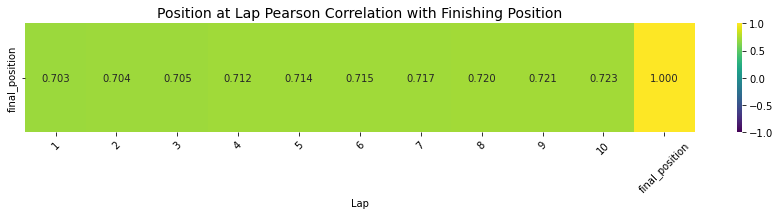

In [10]:
corr_matrix = laps[list(range(1,11)) + ['final_position']].corr()
corr_matrix = corr_matrix.loc[['final_position']]

# Plot the heatmap
plt.figure(figsize=(15, 2))
plt.title('Position at Lap Pearson Correlation with Finishing Position', fontsize=14)
sns.heatmap(corr_matrix, annot=True, fmt='.3f', annot_kws={'size': 10}, vmin=-1, vmax=1, cmap='viridis')
plt.xticks(rotation=45)
plt.xlabel('Lap')
plt.savefig('eda_visualizations/position_at_lap_correlation.png', bbox_inches='tight')

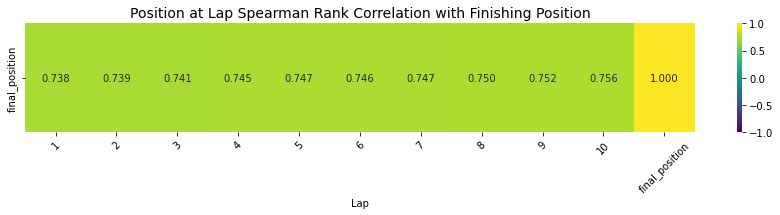

In [11]:

corr_matrix = laps[list(range(1,11)) + ['final_position']].corr(method = 'spearman')
corr_matrix = corr_matrix.loc[['final_position']] 

# Plot the heatmap
plt.figure(figsize=(15, 2))
plt.title('Position at Lap Spearman Rank Correlation with Finishing Position', fontsize=14)
sns.heatmap(corr_matrix, annot=True, fmt='.3f', annot_kws={'size': 10}, vmin=-1, vmax=1, cmap='viridis')
plt.xticks(rotation=45)
plt.xlabel('Lap')
plt.savefig('eda_visualizations/position_at_lap_spearman_correlation.png', bbox_inches='tight')